This notebook analyzes European option pricing using different models (Black-Scholes, Binomial Tree, Monte Carlo) and compares them to CBOE simulated prices.

Import libraries.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import OptionsContract
import Pricer
from helper import load_data_files, calculate_days_to_expiration
import time

Configure parameters.

In [2]:
S0 = 5158.2002  # S&P 500 last price
r = 0.05  # Risk-free rate
current_date = '2025-04-21'  # Current date
dividend_yield = 0.0  # SPX contains no dividends

# Model selection
option_type = 'call'  # 'Call' or 'Put'

Load and Prepare Data

In [3]:
# Load data files
data_frames = load_data_files('../data/raw/european')
current_df = data_frames['spx_quotedata']

# Initialize list for storing calculated prices
calculated_prices = []

 Run Pricing Models.

In [4]:
# Start timer
start = time.perf_counter()

# Run selected model for each option
for index, row in current_df.iterrows():
    # Set K as the strike price
    K = row['Strike']
    # Set T as the time to expiration in years.
    T = calculate_days_to_expiration(current_date, row['Expiration Date'])/365

    option_param = OptionsContract.ContractParam(S0=S0,
                                                 K=K,
                                                 T=T,
                                                 dividend_yield=dividend_yield,
                                                 payoff=option_type,
                                                 exercise='european')
    if option_param.payoff == 'call':
        # Use IV for Call options
        sigma = row['IV']
    else:
        # Use IV1 for Put options
        sigma = row['IV.1']
    
    #Initialize the EuropeanPricer object
    pricer = Pricer.Pricer(option_param, r=r, sigma=sigma, mu=0.1)

    price = pricer.binomial_tree(N=100)

            
    calculated_prices.append(round(price, 2))

# End timer
end = time.perf_counter()
# Print the calculated time
print(f"Execution time: {end - start:.6f} seconds")


Execution time: 0.045108 seconds


Analyze Results.

In [5]:
# Add calculated prices to DataFrame
current_df['My Price'] = calculated_prices

if option_param.payoff == 'call':
    # new columns for My Call Price
    current_df['My Call Price'] = current_df['My Price']
    # new columns for Actual Call Price
    current_df['Actual Call Price'] = (current_df['Bid'] + current_df['Ask']) / 2
    # new columns for Call Absolute Error
    current_df['Call Absolute Error'] = abs((current_df['My Price'] - current_df['Actual Call Price']))
    # Calculate mean absolute error for Call options
    mean_abs_error = current_df['Call Absolute Error'].mean()
    # Print mean absolute error
    print(f"Mean Absolute Error for Calls: {mean_abs_error}")
else:
    current_df['My Put Price'] = current_df['My Price']
    current_df['Actual Put Price'] = (current_df['Bid.1'] + current_df['Ask.1']) / 2
    current_df['Put Absolute Error'] = abs((current_df['My Price'] - current_df['Actual Put Price']))
    mean_abs_error = current_df['Put Absolute Error'].mean()
    print(f"Mean Absolute Error for Puts: {mean_abs_error}")

# Create simplified expiration date for plotting
current_df['Expiration MD'] = pd.to_datetime(current_df['Expiration Date']).dt.strftime('%m-%d')

Mean Absolute Error for Calls: 3.5363333333333324


Visualization.

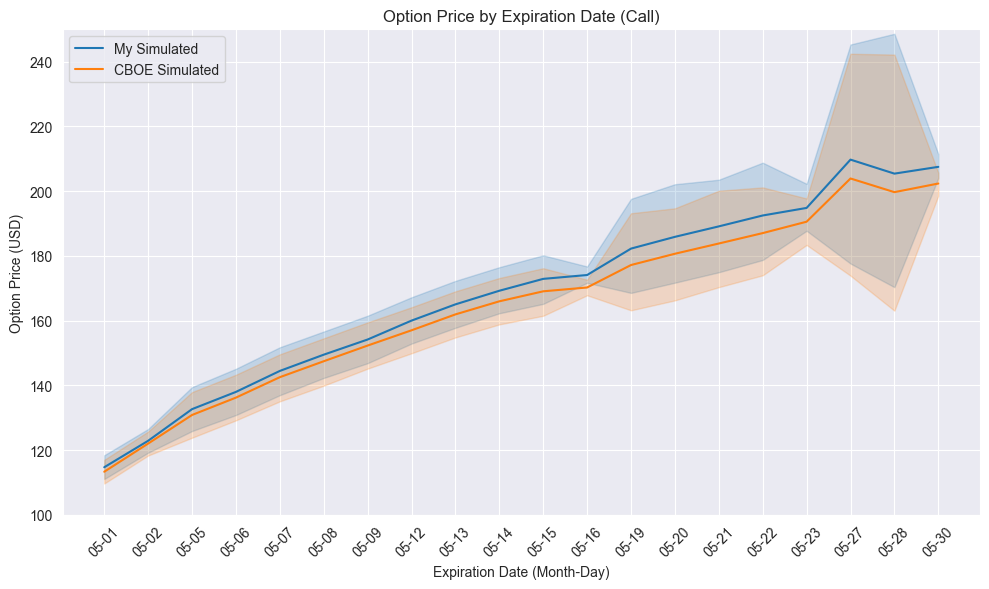

In [6]:
# Plot results based on option type
plt.figure(figsize=(10, 6))

if option_param.payoff == 'call':
    # Plot Call option prices
    sns.lineplot(data=current_df, x='Expiration MD', y='My Call Price', label='My Simulated')
    # Plot Actual Call Price
    sns.lineplot(data=current_df, x='Expiration MD', y='Actual Call Price', label='CBOE Simulated')
    # Plot Call Absolute Error
    plt.title('Option Price by Expiration Date (Call)')
    # Set y-axis limits for Call options
    plt.ylim(100, 250)
else:
    sns.lineplot(data=current_df, x='Expiration MD', y='My Put Price', label='My Simulated')
    sns.lineplot(data=current_df, x='Expiration MD', y='Actual Put Price', label='CBOE Simulated')
    plt.title('Option Price by Expiration Date (Put)')
    plt.ylim(100, 240)
# Set plot visuals
plt.xlabel('Expiration Date (Month-Day)')
plt.ylabel('Option Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()